# Create Financial Data Structures: mlfinlab

The purpose of this notebook is to act as a tutorial to bridge the gap between idea and implementation. In particular we will be looking at how to create the various financial data structures and how to format your data so that you can make use of the mlfinlab package.

For this tutorial we made use of the sample data provided by TickWrite LLC. Using S&P500 E-mini futures. https://s3-us-west-2.amazonaws.com/tick-data-s3/downloads/ES_Sample.zip

Note: we have also included the zip file in this repo as ES_Trades.csv.zip. You will need to unzip this file to use it in this notebook.

In [1]:
import mlfinlab as ml

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Read data
data = pd.read_csv('./tutorial_data/ES_Trades/ES_Trades.csv')
data.head()

,Symbol,Date,Time,Price,Volume,Market Flag,Sales Condition,Exclude Record Flag,Unfiltered Price
0,ESU13,09/01/2013,17:00:00.083,1640.25,8,E,0,NaN,1640.25
1,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25
2,ESU13,09/01/2013,17:00:00.083,1640.25,2,E,0,NaN,1640.25
3,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25
4,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25


--- 

## Format Data

Many data vendors will let you choose the format of your raw tick data files. We want to only focus on the following 3 columns: date_time, price, volume. The reason for this is to minimise the size of the csv files and the amount of time when reading in the files.

Our data is sourced from TickData LLC which provide TickWrite 7, to aid in the formatting of saved files. This allows us to save csv files in the format date_time, price, volume.

For this tutorial we will assume that you need to first do some preprocessing and then save your data to a csv file.

In [3]:
# Format the Data
date_time = data['Date'] + ' ' + data['Time'] # Dont convert to datetime here, it will take forever to convert.
new_data = pd.concat([date_time, data['Price'], data['Volume']], axis=1)
new_data.columns = ['date', 'price', 'volume']
print(new_data.head())
print('\n')
print('Rows:', new_data.shape[0])

                      date    price  volume
0  09/01/2013 17:00:00.083  1640.25       8
1  09/01/2013 17:00:00.083  1640.25       1
2  09/01/2013 17:00:00.083  1640.25       2
3  09/01/2013 17:00:00.083  1640.25       1
4  09/01/2013 17:00:00.083  1640.25       1


Rows: 5454950


### Save to csv

Initially, your instinct may be to pass mlfinlab package an in-memory DataFrame object but the truth is when you're running the function in production, your raw tick data csv files will be way too large to hold in memory. We used the subset 2011 to 2019 and it was more than 25 gigs. It is for this reason that the mlfinlab package requires a file path to read the raw data files from disk.

In [4]:
# Save to csv
new_data.to_csv('./tutorial_data/raw_tick_data.csv', index=False)

---

## Use mlfinlab: Create Data Structures
Next we create the various data structures. In this example we focus on the standard bar types but the information driven bars are also available.

In [6]:
print('Creating Dollar Bars')
dollar = ml.data_structures.get_dollar_bars('./tutorial_data/raw_tick_data.csv',
                                            threshold=70_000_000,
                                            batch_size=1_000_000,
                                            verbose=True,
                                            to_csv=True,
                                            output_path='./tutorial_data/dollar_bars.csv')
print('Creating Volume Bars')
volume = ml.data_structures.get_volume_bars('./tutorial_data/raw_tick_data.csv',
                                            threshold=28_000,
                                            batch_size=1_000_000,
                                            verbose=True,
                                            to_csv=True,
                                            output_path='./tutorial_data/volume_bars.csv')
print('Creating Tick Bars')
tick = ml.data_structures.get_tick_bars('./tutorial_data/raw_tick_data.csv',
                                          threshold=5_500,
                                          batch_size=1_000_000,
                                          verbose=True,
                                          to_csv=True,
                                          output_path='./tutorial_data/tick_bars.csv')

print('Creating Time Bars')
time = ml.data_structures.get_time_bars('./tutorial_data/raw_tick_data.csv',
                                              resolution='MIN',
                                              num_units=30,
                                              batch_size=1_000_000,
                                              verbose=True,
                                              to_csv=True,
                                              output_path='./tutorial_data/time_bars.csv')

Creating Dollar Bars
Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Returning bars 

Creating Volume Bars
Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Returning bars 

Creating Tick Bars
Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Returning bars 

Creating Time Bars
Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Returning bars 



### Out of Memory?
In the event that your dollar bars DataFrame is too large to fit into memory, you will need to save them to a csv file. Simply uncomment the code below to do so.

In [7]:
print('Creating Dollar Bars')
# dollar = ml.data_structures.get_dollar_bars('tutorial_data/raw_tick_data.csv', threshold=70000000, batch_size=1000000, verbose=False, to_csv=True, output_path='./tutorial_data/dollar_bars.csv')

print('Creating Volume Bars')
# volume = ml.data_structures.get_volume_bars('tutorial_data/raw_tick_data.csv', threshold=28000, batch_size=1000000, verbose=False, to_csv=True, output_path='./tutorial_data/volume_bars.csv')

print('Creating Tick Bars')
# tick = ml.data_structures.get_tick_bars('tutorial_data/raw_tick_data.csv', threshold=5500, batch_size=1000000, verbose=False, to_csv=True, output_path='./tutorial_data/tick_bars.csv')

Creating Dollar Bars
Creating Volume Bars
Creating Tick Bars


### Load bar data

In [16]:
# Read from csv
time_bars = pd.read_csv('./tutorial_data/time_bars.csv', index_col=0, parse_dates=True)
dollar_bars = pd.read_csv('./tutorial_data/dollar_bars.csv', index_col=0, parse_dates=True)
volume_bars = pd.read_csv('./tutorial_data/volume_bars.csv', index_col=0, parse_dates=True)
tick_bars = pd.read_csv('./tutorial_data/tick_bars.csv', index_col=0, parse_dates=True)

### Confirm Sampling:

The following cell confrims the sampling techniques are working at the desired thresholds.

In [17]:
# Confirm the dollar sampling
dollar_bars['value'] = dollar_bars['close'] * dollar_bars['volume']
dollar_bars.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value,value
date_time,,,,,,,,,,
2013-09-01 21:34:39.298,11207,1640.25,1643.5,1639.00,1640.75,42862,21896,11207,70347610.00,70325826.5
2013-09-02 02:56:24.209,26547,1640.75,1646.0,1640.25,1644.50,42585,24320,15340,70000546.50,70031032.5
2013-09-02 06:37:33.128,40473,1644.50,1647.5,1644.25,1647.50,42580,23167,13926,70095794.25,70150550.0
2013-09-02 09:34:46.141,51328,1647.50,1648.5,1645.25,1647.00,42535,23904,10855,70053015.75,70055145.0
2013-09-02 22:55:20.297,64261,1647.00,1648.5,1645.25,1648.00,42512,23884,12933,70024910.50,70059776.0


In [18]:
volume_bars.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2013-09-01 19:32:23.387,7171,1640.25,1642.00,1639.00,1642.00,28031,15442,7171,45991914.75
2013-09-02 01:18:21.928,16133,1642.00,1644.00,1640.25,1643.50,28003,14566,8962,45992828.50
2013-09-02 02:50:32.992,25976,1643.50,1646.00,1642.25,1644.75,28000,15550,9843,46039902.25
2013-09-02 04:57:09.236,35968,1644.75,1647.25,1643.75,1646.00,28000,14211,9992,46082594.25
2013-09-02 07:04:32.076,43461,1646.00,1648.50,1645.75,1647.50,28013,17300,7493,46139513.25


---
## Analyze Statistical Properties

Now we turn to analyze the statistical properties of the new data structures. For this exercise we have included csv files of the data types.

### Measure Stability

In [20]:
# Downsample to weekly periods
time_count = time_bars['close'].resample('W', label='right').count()
tick_count = tick_bars['close'].resample('W', label='right').count()
volume_count = volume_bars['close'].resample('W', label='right').count()
dollar_count = dollar_bars['close'].resample('W', label='right').count()

count_df = pd.concat([time_count, tick_count, volume_count, dollar_count], axis=1)
count_df.columns = ['time', 'tick', 'volume', 'dollar']

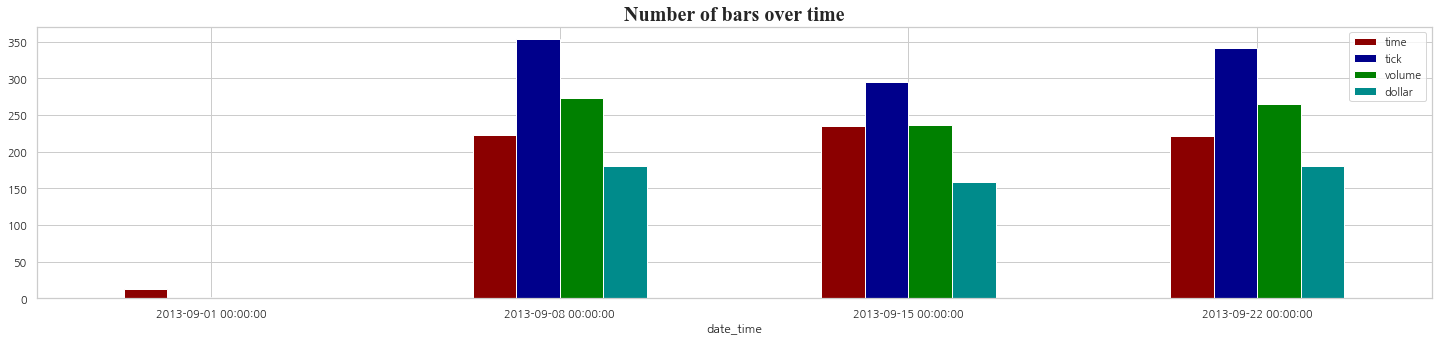

In [21]:
# Plot Number of Bars Over Time
count_df.loc[:, ['time', 'tick', 'volume', 'dollar']].plot(kind='bar', figsize=[25, 5], color=('darkred', 'darkblue', 'green', 'darkcyan'))
plt.title('Number of bars over time', loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
plt.xticks(rotation=0)
plt.show()

This stability test will work better on your own tick data over a much longer period. This sample only contains 20 days.

### Partial Return to Normality

In [26]:
# Calculate log returns
time_returns = np.log(time_bars['close']).diff().dropna()
tick_returns = np.log(tick_bars['close']).diff().dropna()
volume_returns = np.log(volume_bars['close']).diff().dropna()
dollar_returns = np.log(dollar_bars['close']).diff().dropna()
norm_dist = np.random.normal(0,0.1,10000)

In [28]:
print('Test Statistics: (jarque-bera value, p-value)')
print('Time:', '\t', stats.jarque_bera(time_returns))
print('Tick:', '\t', stats.jarque_bera(tick_returns))
print('Volume: ', stats.jarque_bera(volume_returns))
print('Dollar: ', stats.jarque_bera(dollar_returns))
print('Norm dist:', '\t', stats.jarque_bera(norm_dist))

Test Statistics: (jarque-bera value, p-value)
Time: 	 (23040.91302523319, 0.0)
Tick: 	 (12151.451482641653, 0.0)
Volume:  (9107.044443544652, 0.0)
Dollar:  (5931.62812501079, 0.0)
Norm dist: 	 (0.5923418385445065, 0.7436603112779313)


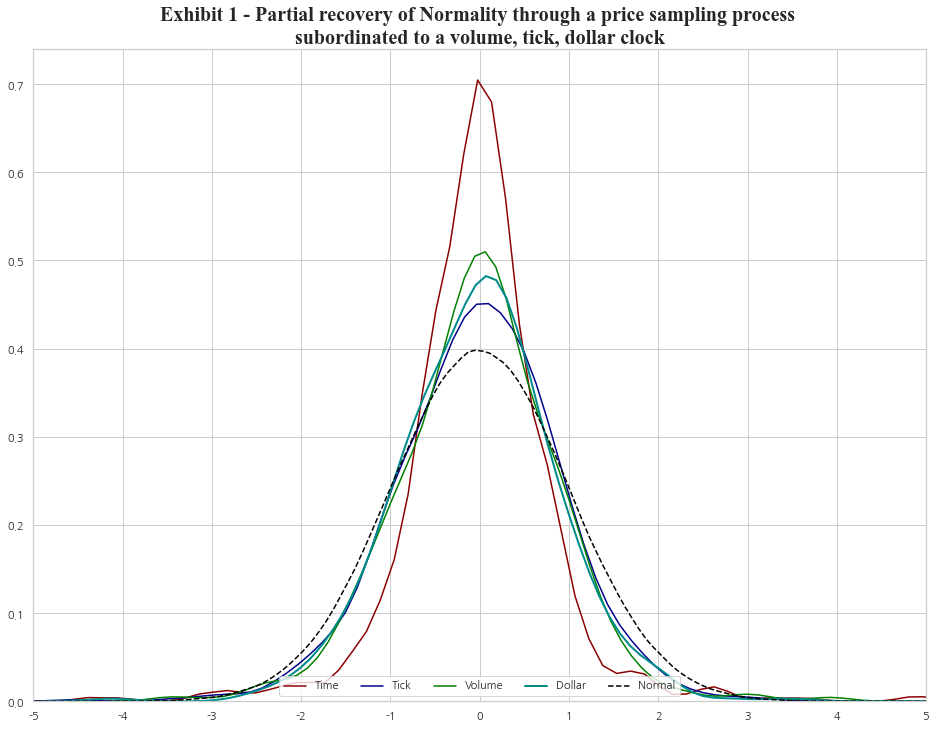

In [29]:
# Calculate the differences
time_diff = time_returns
tick_diff = tick_returns
volume_diff = volume_returns
dollar_diff = dollar_returns

# Standardize the data
time_standard = (time_diff - time_diff.mean()) / time_diff.std()
tick_standard = (tick_diff - tick_diff.mean()) / tick_diff.std()
volume_standard = (volume_diff - volume_diff.mean()) / volume_diff.std()
dollar_standard = (dollar_diff - dollar_diff.mean()) / dollar_diff.std()

# Plot the Distributions
plt.figure(figsize=(16,12))
sns.kdeplot(time_standard, label="Time", color='darkred')
sns.kdeplot(tick_standard, label="Tick", color='darkblue')
sns.kdeplot(volume_standard, label="Volume", color='green')
sns.kdeplot(dollar_standard, label="Dollar", linewidth=2, color='darkcyan')
sns.kdeplot(np.random.normal(size=1000000), label="Normal", color='black', linestyle="--")

plt.xticks(range(-5, 6))
plt.legend(loc=8, ncol=5)
plt.title('Exhibit 1 - Partial recovery of Normality through a price sampling process \nsubordinated to a volume, tick, dollar clock',
          loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
plt.xlim(-5, 5)
plt.show()

---

## Conclusion

The following notebook showed how the mlfinlab package could be used to create new financial data structures that have better statistical properties. The same work can be extended to the information-driven bars which are included in the package. The following links to a notebook that analyzes the properties of [Imbalance Bars](https://github.com/hudson-and-thames/research/blob/master/Chapter2/2019-04-11_OP_Dollar-Imbalance-Bars.ipynb).

If you enjoyed this notebook then please be sure to star our repo!
* [mlfinlab](https://github.com/hudson-and-thames/mlfinlab)
* [research](https://github.com/hudson-and-thames/research)